In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('framingham.csv')

In [4]:
df=df.dropna()

In [5]:
df = df.drop(['education'], axis=1) 

In [6]:
df = df.drop(['currentSmoker'], axis=1) 

In [7]:
df_top = df
df_top = df_top.drop(['BMI'], axis=1)
df_top = df_top.drop(['prevalentStroke'], axis=1)
df_top = df_top.drop(['heartRate'], axis=1)

In [7]:
top= ['sysBP','glucose','age','totChol','cigsPerDay','diaBP','prevalentHyp','diabetes','BPMeds','male']
x=df[top]
y = df.iloc[:,-1]

In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [9]:
# the numbers before SMOTE
num_before = dict(Counter(y))

#perform SMOTE

# define pipeline
over = SMOTE(sampling_strategy=0.8)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_smote, y_smote = pipeline.fit_resample(x, y)


#the numbers after SMOTE
num_after =dict(Counter(y_smote))

In [10]:
print(num_before, num_after)

{0: 3101, 1: 557} {0: 3100, 1: 2480}


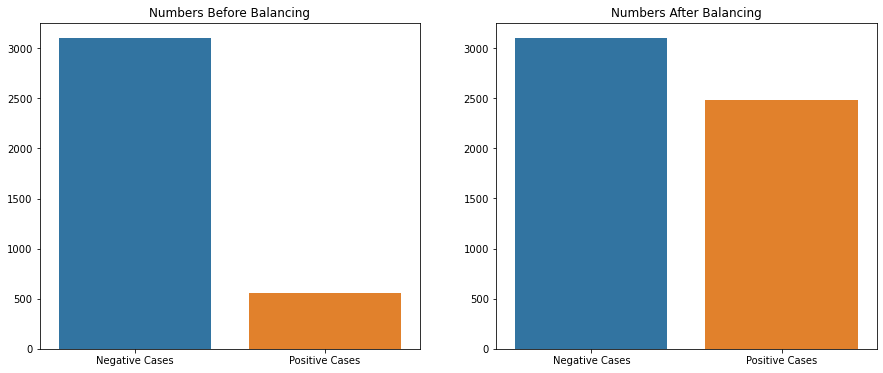

In [11]:
labels = ["Negative Cases","Positive Cases"]
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(labels, list(num_before.values()))
plt.title("Numbers Before Balancing")
plt.subplot(1,2,2)
sns.barplot(labels, list(num_after.values()))
plt.title("Numbers After Balancing")
plt.show()

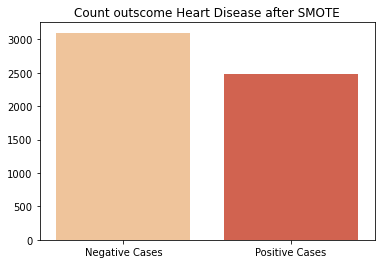

In [12]:
sns.barplot(labels, list(num_after.values()),palette="OrRd")
plt.title("Count outscome Heart Disease after SMOTE")
plt.show()

In [13]:
# new dataset
new_data = pd.concat([pd.DataFrame(X_smote), pd.DataFrame(y_smote)], axis=1)
new_data.columns = ['sysBP','glucose','age','totChol','cigsPerDay','diaBP','prevalentHyp','diabetes','BPMeds','male',
                    'TenYearCHD']
new_data.head()

,sysBP,glucose,age,totChol,cigsPerDay,diaBP,prevalentHyp,diabetes,BPMeds,male,TenYearCHD
0,134.0,99.0,47,328.0,20.0,87.0,0,0,0.0,0,0
1,120.0,66.0,40,208.0,40.0,80.0,0,0,0.0,1,0
2,145.0,75.0,62,240.0,0.0,82.5,0,0,0.0,0,0
3,123.0,85.0,37,261.0,0.0,75.0,0,0,0.0,0,0
4,105.0,67.0,42,197.0,0.0,84.0,0,0,0.0,0,0


In [14]:
X_new = new_data[top]
y_new= new_data.iloc[:,-1]

In [15]:
# split the dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_new,y_new,test_size=.2,random_state=0)

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

# 1. Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import recall_score,precision_score,classification_report,roc_auc_score,roc_curve

In [18]:
# search for optimun parameters using gridsearch
params = {'penalty':['l1','l2'],
         'C':[0.01,0.1,1,10,100],
         'class_weight':['balanced',None]}
logistic_clf = GridSearchCV(LogisticRegression(),param_grid=params,cv=10)
#train the classifier
logistic_clf.fit(X_train,y_train)

logistic_clf.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}

In [19]:
#make predictions
logistic_predict = logistic_clf.predict(X_test)
#Accuracy
log_accuracy = accuracy_score(y_test,logistic_predict)
print(f"Using logistic regression we get an accuracy of {round(log_accuracy*100,2)}%")

Using logistic regression we get an accuracy of 64.7%


<AxesSubplot:>

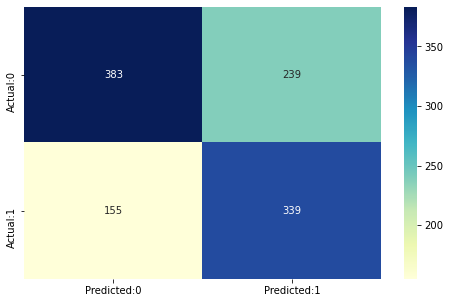

In [21]:
cm=confusion_matrix(y_test,logistic_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [25]:
print(classification_report(y_test,logistic_predict))

              precision    recall  f1-score   support

           0       0.71      0.62      0.66       622
           1       0.59      0.69      0.63       494

    accuracy                           0.65      1116
   macro avg       0.65      0.65      0.65      1116
weighted avg       0.66      0.65      0.65      1116



In [26]:
log_precision = precision_score(y_test,logistic_predict)
log_precision

0.5865051903114187

In [27]:
log_recall = recall_score(y_test,logistic_predict)
log_recall

0.6862348178137652

In [28]:
log_f1 = f1_score(y_test, logistic_predict)
print(f'The f1 score for Log reg is {round(log_f1*100,2)}%')

The f1 score for Log reg is 63.25%


In [29]:
sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.6157556270096463
Specificity :  0.6862348178137652


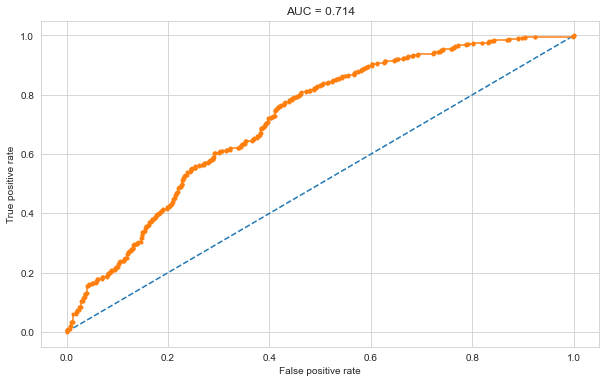

In [32]:
# ROC curve and AUC 
probs = logistic_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

In [33]:
log_auc

0.7142819948709269

# 2. KNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [35]:
# search for optimun parameters using gridsearch
params= {'n_neighbors': np.arange(1, 10)}
grid_search = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = params, 
                           scoring = 'accuracy', cv = 10, n_jobs = -1)
knn_clf = GridSearchCV(KNeighborsClassifier(),params,cv=3, n_jobs=-1)

In [36]:
# train the model
knn_clf.fit(X_train,y_train)
knn_clf.best_params_ 

{'n_neighbors': 1}

In [37]:
# predictions
knn_predict = knn_clf.predict(X_test)

In [38]:
#accuracy
knn_accuracy = accuracy_score(y_test,knn_predict)
print(f"Using k-nearest neighbours we get an accuracy of {round(knn_accuracy*100,2)}%")

Using k-nearest neighbours we get an accuracy of 81.18%


<AxesSubplot:>

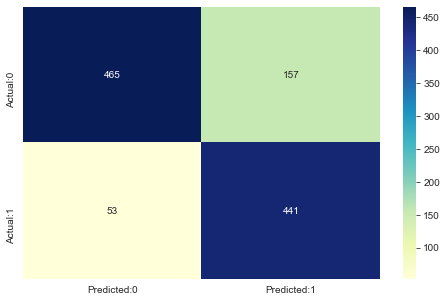

In [40]:
cm2=confusion_matrix(y_test,knn_predict)
conf_matrix=pd.DataFrame(data=cm2,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [41]:
print(classification_report(y_test,knn_predict))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       622
           1       0.74      0.89      0.81       494

    accuracy                           0.81      1116
   macro avg       0.82      0.82      0.81      1116
weighted avg       0.83      0.81      0.81      1116



In [42]:
knn_f1 = f1_score(y_test, knn_predict)
print(f'The f1 score for K nearest neignbours is {round(knn_f1*100,2)}%')

The f1 score for K nearest neignbours is 80.77%


In [43]:
knn_precision = precision_score(y_test,knn_predict)
knn_precision

0.7374581939799331

In [44]:
knn_recall = recall_score(y_test,knn_predict)
knn_recall

0.8927125506072875

In [45]:
sensitivity1 = cm2[0,0]/(cm2[0,0]+cm2[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm2[1,1]/(cm2[1,0]+cm2[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.747588424437299
Specificity :  0.8927125506072875


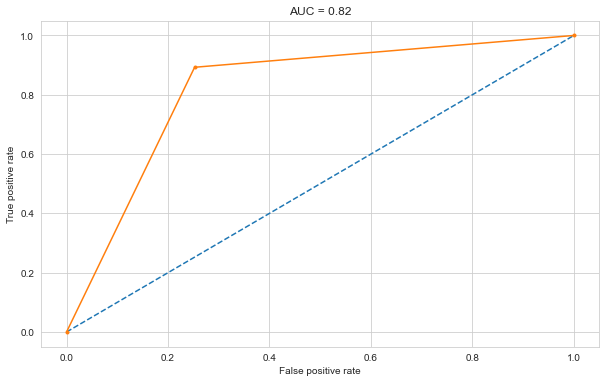

In [48]:
# ROC curve and AUC 
probs = knn_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
knn_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(knn_auc,3)}")
plt.show()

# PIPELINE

In [50]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [51]:
from sklearn.pipeline import Pipeline

classifiers = [LogisticRegression(),SVC(),DecisionTreeClassifier(),KNeighborsClassifier(2),RandomForestClassifier()]

for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    print("The accuracy score of {0} is: {1:.2f}%".format(classifier,(pipe.score(X_test, y_test)*100)))

The accuracy score of LogisticRegression() is: 66.04%
The accuracy score of SVC() is: 68.55%
The accuracy score of DecisionTreeClassifier() is: 76.43%
The accuracy score of KNeighborsClassifier(n_neighbors=2) is: 80.56%
The accuracy score of RandomForestClassifier() is: 86.20%


# 3. RANDOM FOREST CLASSIFIER

In [78]:
RFC_clf=RandomForestClassifier(n_estimators=300,min_samples_split=5,max_features='auto')

In [79]:
RFC_clf.fit(X_train,y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=300)

In [80]:
RFC_predict = RFC_clf.predict(X_test)

In [81]:
#accuracy
RFC_accuracy = accuracy_score(y_test,RFC_predict)
print(f"Using RFC we get an accuracy of {round(RFC_accuracy*100,2)}%")

Using RFC we get an accuracy of 84.95%


In [82]:
print(classification_report(y_test,RFC_predict))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       622
           1       0.84      0.82      0.83       494

    accuracy                           0.85      1116
   macro avg       0.85      0.85      0.85      1116
weighted avg       0.85      0.85      0.85      1116



In [83]:
sensitivity1 = cm3[0,0]/(cm3[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm3[1,1]/(cm3[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.7668810289389068
Specificity :  0.7004048582995951


<AxesSubplot:>

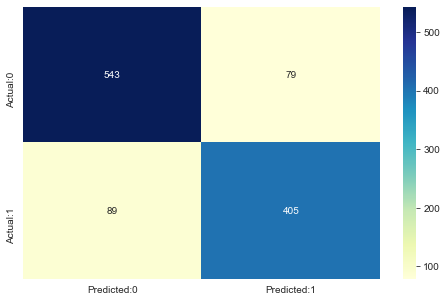

In [84]:
cm3=confusion_matrix(y_test,RFC_predict)
conf_matrix=pd.DataFrame(data=cm3,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

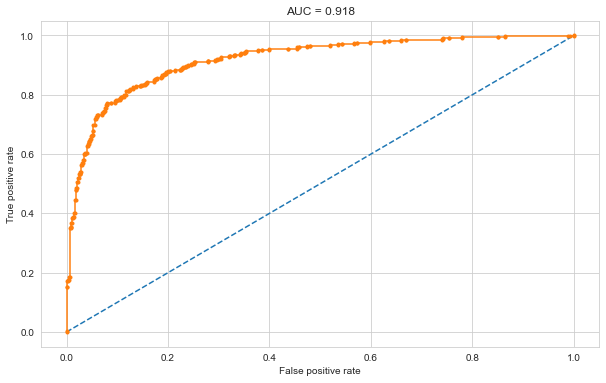

In [85]:
# ROC curve and AUC 
probs = RFC_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
rfc_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(rfc_auc,3)}")
plt.show()

In [106]:
#Cross validation
from sklearn.model_selection import cross_val_score

In [110]:
cv_results = cross_val_score(RFC_clf, x, y, cv=5) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.8510929  0.85245902 0.84972678 0.84815321 0.84268126]
The Cross Validation accuracy is: 84.88%


# 4. DECISION TREE

In [67]:
dtree= DecisionTreeClassifier()

In [68]:
# grid search for optimum parameters
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11]}
tree_clf = GridSearchCV(dtree, param_grid=params, n_jobs=-1)
# train the model
tree_clf.fit(X_train,y_train)
tree_clf.best_params_ 

{'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 6}

In [69]:
# predictions
tree_predict = tree_clf.predict(X_test)

In [70]:
#accuracy
tree_accuracy = accuracy_score(y_test,tree_predict)
print(f"Using Decision Trees we get an accuracy of {round(tree_accuracy*100,2)}%")

Using Decision Trees we get an accuracy of 73.75%


<AxesSubplot:>

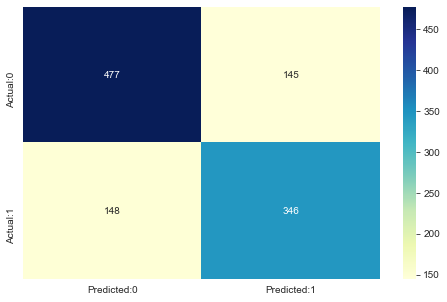

In [71]:
cm1=confusion_matrix(y_test,tree_predict)
conf_matrix=pd.DataFrame(data=cm1,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [72]:
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.7668810289389068
Specificity :  0.7004048582995951


In [75]:
tree_f1 = f1_score(y_test, tree_predict)
print(f'The f1 score for K nearest neignbours is {round(tree_f1*100,2)}%')

The f1 score for K nearest neignbours is 70.25%


In [77]:
tree_precision = precision_score(y_test, tree_predict)
tree_precision

0.7046843177189409

In [74]:
print(classification_report(y_test,tree_predict))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77       622
           1       0.70      0.70      0.70       494

    accuracy                           0.74      1116
   macro avg       0.73      0.73      0.73      1116
weighted avg       0.74      0.74      0.74      1116



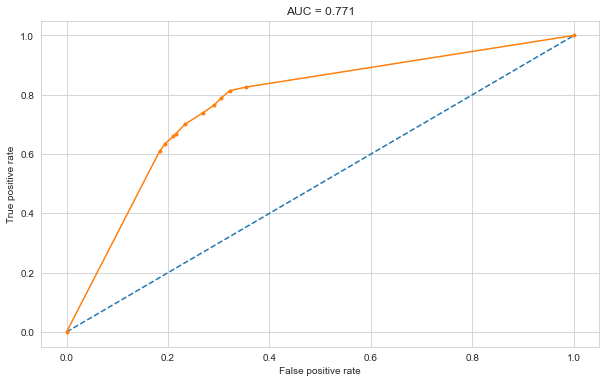

In [73]:
# ROC curve and AUC 
probs = tree_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
tree_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(tree_auc,3)}")
plt.show()